In [ ]:
import pandas as pd, numpy as np, ast, joblib, os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load and clean
df = pd.read_excel("/content/sample_data/full_balanced_dataset_merged.xlsx")
df.columns = [col.strip().lower() for col in df.columns]
df.dropna(subset=["student mfcc", "teacher mfcc", "labels"], inplace=True)

def parse_mfcc(s):
    try: return np.array(ast.literal_eval(s))
    except: return np.array([])

df["student mfcc"] = df["student mfcc"].apply(parse_mfcc)
df["teacher mfcc"] = df["teacher mfcc"].apply(parse_mfcc)
df = df[(df["student mfcc"].apply(len) == 13) & (df["teacher mfcc"].apply(len) == 13)]

# Combine MFCCs into sequence
X = np.stack([np.vstack([s, t]).T for s, t in zip(df["student mfcc"], df["teacher mfcc"])])  # Shape: (N, 13, 2)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["labels"].str.strip())

num_classes = len(np.unique(y))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Define model
model = Sequential([
    LSTM(64, input_shape=(13, 2), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat),
                    epochs=50, batch_size=32, verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3924 - loss: 1.3588 - val_accuracy: 0.4526 - val_loss: 1.2900
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4345 - loss: 1.3094 - val_accuracy: 0.4526 - val_loss: 1.2832
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4571 - loss: 1.2829 - val_accuracy: 0.4489 - val_loss: 1.2420
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4801 - loss: 1.2395 - val_accuracy: 0.4982 - val_loss: 1.2141
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4887 - loss: 1.2249 - val_accuracy: 0.4964 - val_loss: 1.1842
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4938 - loss: 1.1895 - val_accuracy: 0.5128 - val_loss: 1.1611
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4855 - loss: 1.1888 - val_accuracy: 0.5310 - val_loss: 1.1282
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5039 - loss: 1.1550 - val_accuracy: 0.5146 - val_loss: 1.1188


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
              precision    recall  f1-score   support

     enquiry       0.88      0.15      0.26       100
    question       0.62      0.82      0.71       248
  suggestion       0.65      1.00      0.79       100
 sympathetic       0.43      0.20      0.27       100

    accuracy                           0.62       548
   macro avg       0.64      0.54      0.51       548
weighted avg       0.64      0.62      0.56       548



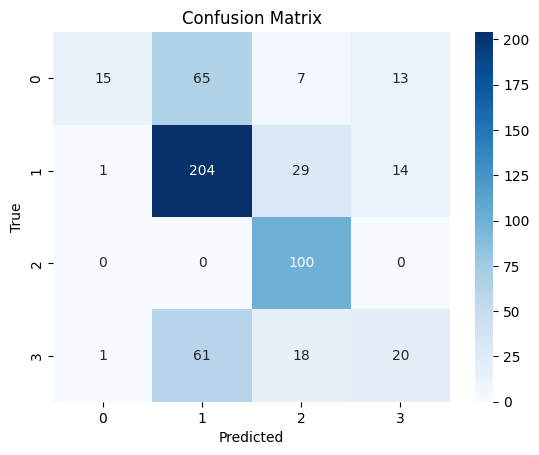

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_dir = "/content/drive/MyDrive/TeacherPredictionModels"
os.makedirs(save_dir, exist_ok=True)

model.save(f"{save_dir}/lstm_teacher_model.h5")
joblib.dump(label_encoder, f"{save_dir}/lstm_label_encoder.pkl")

print(" LSTM model and label encoder saved to Drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 LSTM model and label encoder saved to Drive


In [ ]:
import librosa
from tensorflow.keras.models import load_model

# Load models
model = load_model(f"{save_dir}/lstm_teacher_model.h5")
label_encoder = joblib.load(f"{save_dir}/lstm_label_encoder.pkl")

def extract_mfcc(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfcc.mean(axis=1)

# Audio paths
student_audio = "/content/sample_data/148_s_26.mp3"
teacher_audio = "/content/sample_data/148_t_26.mp3"

student_mfcc = extract_mfcc(student_audio)
teacher_mfcc = extract_mfcc(teacher_audio)

sequence = np.vstack([student_mfcc, teacher_mfcc]).T.reshape(1, 13, 2)
predicted_class = np.argmax(model.predict(sequence))
label = label_encoder.inverse_transform([predicted_class])[0]

print(f" Predicted Teacher Response (LSTM): {label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
 Predicted Teacher Response (LSTM): suggestion
